<a href="https://colab.research.google.com/github/carlaolivei/Analise-Modelagem-dados-COVID-19/blob/main/aprendizado_nao_supervisiosado_kmeans_dados_covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msgo
import seaborn as sns
import plotly.express as px
from scipy import stats
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Normalizer,RobustScaler
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
pd.options.display.float_format = '{:.2f}'.format

In [3]:
## https://nextjournal.com/gkoehler/machine-translation-seq2seq-cpu
## liberando o acesso ao drive
## use essa opção se utilizar o Google Drive, neste caso basta apenas colocar o arquivo em uma pasta do Drive e copiar o caminho
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#utilize esta opção se desejar fazer o upload do arquivo
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

print("Upload concluído!")

Upload concluído!


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Inteligência Artificial/kaggle/My_datasets/Covid-19/df_covid19_countries.csv')
df.tail(1)

,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,population,vaccination_ratio,prevalence,incidence
234801,Zimbabwe,2023-01-04,259981.00,0.00,0.00,5637.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16320539.00,0.00,1.59,0.00


In [5]:
df.shape

(234802, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234802 entries, 0 to 234801
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   location                 234802 non-null  object 
 1   date                     234802 non-null  object 
 2   total_cases              234802 non-null  float64
 3   new_cases                234802 non-null  float64
 4   new_cases_smoothed       234802 non-null  float64
 5   total_deaths             234802 non-null  float64
 6   new_deaths               234802 non-null  float64
 7   new_deaths_smoothed      234802 non-null  float64
 8   reproduction_rate        234802 non-null  float64
 9   total_vaccinations       234802 non-null  float64
 10  people_vaccinated        234802 non-null  float64
 11  people_fully_vaccinated  234802 non-null  float64
 12  total_boosters           234802 non-null  float64
 13  population               234802 non-null  float64
 14  vacc

In [7]:
df.isnull().sum()

location                   0
date                       0
total_cases                0
new_cases                  0
new_cases_smoothed         0
total_deaths               0
new_deaths                 0
new_deaths_smoothed        0
reproduction_rate          0
total_vaccinations         0
people_vaccinated          0
people_fully_vaccinated    0
total_boosters             0
population                 0
vaccination_ratio          0
prevalence                 0
incidence                  0
dtype: int64

In [8]:
df['location'].unique().shape

(236,)

<h1>Clusterização</h1>

Selecionando country para fazer merge posteriormente

In [9]:
df_covid = df[['location']]
df_covid = df.set_index('location')
df_covid = df.reset_index().groupby('location').nunique()
df_covid.shape[0]

236

Lista da features

In [10]:
#features_list = ['location','total_vaccinations','new_deaths','population']
#features_list = ['location','total_vaccinations', 'new_cases', 'new_deaths']
features_list = ['location','total_vaccinations', 'new_cases', 'new_deaths','population']

Criando um dataframe com a lista de features

In [11]:
df2=df
df3 = df2[df2.columns.intersection(features_list)]
df3.head(1)

,location,new_cases,new_deaths,total_vaccinations,population
0,Afghanistan,5.00,0.00,0.00,41128772.00


In [12]:
df_new_cases = df3.groupby('location').new_cases.mean().reset_index()
df_new_cases.columns = ['location','new_cases']
df_new_cases.head(1)

,location,new_cases
0,Afghanistan,198.59


In [13]:
df_covid_features = df_new_cases
df_covid_features

,location,new_cases
0,Afghanistan,198.59
1,Albania,319.44
2,Algeria,259.56
3,Andorra,45.96
4,Angola,102.93
...,...,...
231,Wallis and Futuna,4.24
232,Western Sahara,0.00
233,Yemen,11.95
234,Zambia,327.36


In [14]:
df_total_vaccinations = df3.groupby('location').total_vaccinations.mean().reset_index()
df_total_vaccinations.columns = ['location','total_vaccinations']
df_total_vaccinations

,location,total_vaccinations
0,Afghanistan,477270.45
1,Albania,354844.52
2,Algeria,285547.61
3,Andorra,4569.84
4,Angola,869973.22
...,...,...
231,Wallis and Futuna,576.30
232,Western Sahara,0.00
233,Yemen,24803.42
234,Zambia,555458.85


In [15]:
# adiciona esses dados em nosso df principal
df_covid_features = pd.merge(df_covid_features, df_total_vaccinations, on='location')
df_covid_features

,location,new_cases,total_vaccinations
0,Afghanistan,198.59,477270.45
1,Albania,319.44,354844.52
2,Algeria,259.56,285547.61
3,Andorra,45.96,4569.84
4,Angola,102.93,869973.22
...,...,...,...
231,Wallis and Futuna,4.24,576.30
232,Western Sahara,0.00,0.00
233,Yemen,11.95,24803.42
234,Zambia,327.36,555458.85


In [16]:
df_new_deaths = df3.groupby('location').new_deaths.mean().reset_index()
df_new_deaths.columns = ['location','new_deaths']
df_new_deaths

,location,new_deaths
0,Afghanistan,7.50
1,Albania,3.44
2,Algeria,6.58
3,Andorra,0.16
4,Angola,1.89
...,...,...
231,Wallis and Futuna,0.01
232,Western Sahara,0.00
233,Yemen,2.16
234,Zambia,3.93


In [17]:
df_covid_features = pd.merge(df_covid_features, df_new_deaths, on='location')
df_covid_features

,location,new_cases,total_vaccinations,new_deaths
0,Afghanistan,198.59,477270.45,7.50
1,Albania,319.44,354844.52,3.44
2,Algeria,259.56,285547.61,6.58
3,Andorra,45.96,4569.84,0.16
4,Angola,102.93,869973.22,1.89
...,...,...,...,...
231,Wallis and Futuna,4.24,576.30,0.01
232,Western Sahara,0.00,0.00,0.00
233,Yemen,11.95,24803.42,2.16
234,Zambia,327.36,555458.85,3.93


In [18]:
df_covid_features

,location,new_cases,total_vaccinations,new_deaths
0,Afghanistan,198.59,477270.45,7.50
1,Albania,319.44,354844.52,3.44
2,Algeria,259.56,285547.61,6.58
3,Andorra,45.96,4569.84,0.16
4,Angola,102.93,869973.22,1.89
...,...,...,...,...
231,Wallis and Futuna,4.24,576.30,0.01
232,Western Sahara,0.00,0.00,0.00
233,Yemen,11.95,24803.42,2.16
234,Zambia,327.36,555458.85,3.93


In [19]:
X = df_covid_features[['new_cases']]

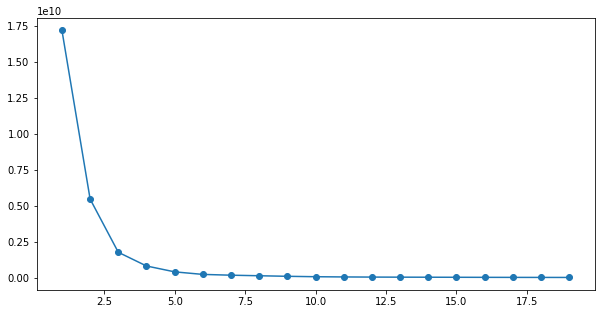

In [20]:
# Elbow método para buscar o número ideal de clusters
inertia = []
num_cluster = range(1,20)
for num in num_cluster:
    km = KMeans(n_clusters = num, random_state=0)
    km = km.fit(X)
    inertia.append(km.inertia_)
    
plt.figure(figsize=(10,5))
plt.plot(num_cluster, inertia,marker='o')

In [21]:
for cn in range(3,10):
    km = KMeans(n_clusters=cn,random_state=0).fit(X)
    Silhouette_Score = silhouette_score(X, km.labels_)
    print('cn = %2.0f' % cn,' - Silhouette Score: %.5f' % Silhouette_Score)

cn =  3  - Silhouette Score: 0.90918
cn =  4  - Silhouette Score: 0.82699
cn =  5  - Silhouette Score: 0.82863
cn =  6  - Silhouette Score: 0.81569
cn =  7  - Silhouette Score: 0.74723
cn =  8  - Silhouette Score: 0.74394
cn =  9  - Silhouette Score: 0.74848


In [22]:
km_new_cases = KMeans(n_clusters=3,random_state=0)
X_km_new_cases = km_new_cases.fit_predict(X)

In [23]:
df_covid_features['new_cases_cluster'] = X_km_new_cases
df_covid_features

,location,new_cases,total_vaccinations,new_deaths,new_cases_cluster
0,Afghanistan,198.59,477270.45,7.50,1
1,Albania,319.44,354844.52,3.44,1
2,Algeria,259.56,285547.61,6.58,1
3,Andorra,45.96,4569.84,0.16,1
4,Angola,102.93,869973.22,1.89,1
...,...,...,...,...,...
231,Wallis and Futuna,4.24,576.30,0.01,1
232,Western Sahara,0.00,0.00,0.00,1
233,Yemen,11.95,24803.42,2.16,1
234,Zambia,327.36,555458.85,3.93,1


In [24]:
df_covid_features.groupby('new_cases_cluster')['new_cases'].describe()

,count,mean,std,min,25%,50%,75%,max
new_cases_cluster,,,,,,,,
0,10.00,28415.48,8394.02,15747.08,22190.47,27320.36,34866.89,41720.34
1,225.00,1134.21,2238.20,0.00,18.17,129.56,1080.73,12881.88
2,1.00,93646.00,NaN,93646.00,93646.00,93646.00,93646.00,93646.00


In [25]:
def ordenar_cluster(cluster_nome, target_nome,df,ascending):
    novo_nome = 'novo' + cluster_nome
    agrupado_por_cluster = df.groupby(cluster_nome)[target_nome].mean().reset_index()
    agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by=target_nome,
                                                                     ascending=ascending).reset_index(drop=True)
    agrupado_por_cluster_ordenado['index'] = agrupado_por_cluster_ordenado.index
    juntando_cluster = pd.merge(df,agrupado_por_cluster_ordenado[[cluster_nome,'index']], on=cluster_nome)
    removendo_dados = juntando_cluster.drop([cluster_nome],axis=1)
    df_final = removendo_dados.rename(columns={"index":cluster_nome})
    return df_final

In [26]:
df_covid_features = ordenar_cluster('new_cases_cluster', 'new_cases',df_covid_features,True)

In [27]:
df_covid_features.groupby('new_cases_cluster')['new_cases'].describe()

,count,mean,std,min,25%,50%,75%,max
new_cases_cluster,,,,,,,,
0,225.00,1134.21,2238.20,0.00,18.17,129.56,1080.73,12881.88
1,10.00,28415.48,8394.02,15747.08,22190.47,27320.36,34866.89,41720.34
2,1.00,93646.00,NaN,93646.00,93646.00,93646.00,93646.00,93646.00


In [28]:
X = df_covid_features[['total_vaccinations']]
km_total_vaccinations = KMeans(n_clusters=3,random_state=0)
X_km_total_vaccinations = km_total_vaccinations.fit_predict(X)

In [29]:
df_covid_features['total_vaccinations_cluster'] = X_km_total_vaccinations
df_covid_features

,location,new_cases,total_vaccinations,new_deaths,new_cases_cluster,total_vaccinations_cluster
0,Afghanistan,198.59,477270.45,7.50,0,0
1,Albania,319.44,354844.52,3.44,0,0
2,Algeria,259.56,285547.61,6.58,0,0
3,Andorra,45.96,4569.84,0.16,0,0
4,Angola,102.93,869973.22,1.89,0,0
...,...,...,...,...,...,...
231,Russia,20098.79,44434160.73,360.72,1,0
232,South Korea,27213.41,50506601.32,30.05,1,0
233,Turkey,15747.08,61306541.72,98.54,1,0
234,United Kingdom,21754.32,56717037.36,198.68,1,0


In [30]:
df_covid_features.groupby('total_vaccinations_cluster')['total_vaccinations'].describe()

,count,mean,std,min,25%,50%,75%,max
total_vaccinations_cluster,,,,,,,,
0,234.00,8492383.29,27418725.33,0.00,17412.53,334796.32,3751443.85,300525512.28
1,1.00,1542132816.22,NaN,1542132816.22,1542132816.22,1542132816.22,1542132816.22,1542132816.22
2,1.00,823188827.49,NaN,823188827.49,823188827.49,823188827.49,823188827.49,823188827.49


In [31]:
df_covid_features = ordenar_cluster('total_vaccinations_cluster', 'total_vaccinations',df_covid_features,True)

In [32]:
df_covid_features.groupby('total_vaccinations_cluster')['total_vaccinations'].describe()

,count,mean,std,min,25%,50%,75%,max
total_vaccinations_cluster,,,,,,,,
0,234.00,8492383.29,27418725.33,0.00,17412.53,334796.32,3751443.85,300525512.28
1,1.00,823188827.49,NaN,823188827.49,823188827.49,823188827.49,823188827.49,823188827.49
2,1.00,1542132816.22,NaN,1542132816.22,1542132816.22,1542132816.22,1542132816.22,1542132816.22


In [33]:
X = df_covid_features[['new_deaths']]
km_new_deaths = KMeans(n_clusters=3,random_state=0)
X_km_new_deaths = km_new_deaths.fit_predict(X)

In [34]:
df_covid_features['new_deaths_cluster'] = X_km_new_deaths
df_covid_features

,location,new_cases,total_vaccinations,new_deaths,new_cases_cluster,total_vaccinations_cluster,new_deaths_cluster
0,Afghanistan,198.59,477270.45,7.50,0,0,2
1,Albania,319.44,354844.52,3.44,0,0,2
2,Algeria,259.56,285547.61,6.58,0,0,2
3,Andorra,45.96,4569.84,0.16,0,0,2
4,Angola,102.93,869973.22,1.89,0,0,2
...,...,...,...,...,...,...,...
231,Turkey,15747.08,61306541.72,98.54,1,0,0
232,United Kingdom,21754.32,56717037.36,198.68,1,0,0
233,United States,93646.00,300525512.28,1015.52,2,0,1
234,China,1769.58,1542132816.22,3.94,0,2,2


In [35]:
df_covid_features.groupby('new_deaths_cluster')['new_deaths'].describe()

,count,mean,std,min,25%,50%,75%,max
new_deaths_cluster,,,,,,,,
0,16.00,163.90,73.00,96.19,114.38,144.38,179.11,360.72
1,3.00,723.13,268.17,488.64,576.93,665.22,840.37,1015.52
2,217.00,6.93,11.85,0.00,0.12,1.36,8.17,64.57


In [36]:
df_covid_features = ordenar_cluster('new_deaths_cluster', 'new_deaths',df_covid_features,True)

In [37]:
df_covid_features.groupby('new_deaths_cluster')['new_deaths'].describe()

,count,mean,std,min,25%,50%,75%,max
new_deaths_cluster,,,,,,,,
0,217.00,6.93,11.85,0.00,0.12,1.36,8.17,64.57
1,16.00,163.90,73.00,96.19,114.38,144.38,179.11,360.72
2,3.00,723.13,268.17,488.64,576.93,665.22,840.37,1015.52


In [38]:
df_final = df_covid_features
df_final

,location,new_cases,total_vaccinations,new_deaths,new_cases_cluster,total_vaccinations_cluster,new_deaths_cluster
0,Afghanistan,198.59,477270.45,7.50,0,0,0
1,Albania,319.44,354844.52,3.44,0,0,0
2,Algeria,259.56,285547.61,6.58,0,0,0
3,Andorra,45.96,4569.84,0.16,0,0,0
4,Angola,102.93,869973.22,1.89,0,0,0
...,...,...,...,...,...,...,...
231,Turkey,15747.08,61306541.72,98.54,1,0,1
232,United Kingdom,21754.32,56717037.36,198.68,1,0,1
233,Brazil,34787.54,167426960.68,665.22,1,0,2
234,United States,93646.00,300525512.28,1015.52,2,0,2


In [39]:
df_final['Pontuacao'] = df_covid_features['new_cases_cluster'] + df_covid_features['total_vaccinations_cluster'] + df_covid_features['new_deaths_cluster']
df_final.head()

,location,new_cases,total_vaccinations,new_deaths,new_cases_cluster,total_vaccinations_cluster,new_deaths_cluster,Pontuacao
0,Afghanistan,198.59,477270.45,7.50,0,0,0,0
1,Albania,319.44,354844.52,3.44,0,0,0,0
2,Algeria,259.56,285547.61,6.58,0,0,0,0
3,Andorra,45.96,4569.84,0.16,0,0,0,0
4,Angola,102.93,869973.22,1.89,0,0,0,0


In [40]:
df_final['Pontuacao'].max()

4

In [42]:
df_final.loc[df_final['Pontuacao']==0,'Gravidade'] = 'Não Preocupante' 
df_final.loc[df_final['Pontuacao']==1,'Gravidade'] = 'Baixa' 
df_final.loc[df_final['Pontuacao']==2,'Gravidade'] = 'Média' 
df_final.loc[df_final['Pontuacao']==3,'Gravidade'] = 'Alta'
df_final.loc[df_final['Pontuacao']==4,'Gravidade'] = 'Gravíssima'  

In [43]:
df_final

,location,new_cases,total_vaccinations,new_deaths,new_cases_cluster,total_vaccinations_cluster,new_deaths_cluster,Pontuacao,Gravidade
0,Afghanistan,198.59,477270.45,7.50,0,0,0,0,Não Preocupante
1,Albania,319.44,354844.52,3.44,0,0,0,0,Não Preocupante
2,Algeria,259.56,285547.61,6.58,0,0,0,0,Não Preocupante
3,Andorra,45.96,4569.84,0.16,0,0,0,0,Não Preocupante
4,Angola,102.93,869973.22,1.89,0,0,0,0,Não Preocupante
...,...,...,...,...,...,...,...,...,...
231,Turkey,15747.08,61306541.72,98.54,1,0,1,2,Média
232,United Kingdom,21754.32,56717037.36,198.68,1,0,1,2,Média
233,Brazil,34787.54,167426960.68,665.22,1,0,2,3,Alta
234,United States,93646.00,300525512.28,1015.52,2,0,2,4,Gravíssima


In [44]:
df_final.columns = ['Pais', 'Media_Novos_Casos', 'Media_Total_de_Vacinados', 'Media_Novas_Mortes', 'new_cases_cluster', 'total_vaccinations_cluster',
                    'new_deaths_cluster', 'Pontuacao', 'Gravidade']

In [45]:
df_final.head(1)

,Pais,Media_Novos_Casos,Media_Total_de_Vacinados,Media_Novas_Mortes,new_cases_cluster,total_vaccinations_cluster,new_deaths_cluster,Pontuacao,Gravidade
0,Afghanistan,198.59,477270.45,7.50,0,0,0,0,Não Preocupante


In [46]:
df_population = df3.groupby('location').population.max().reset_index()
df_population.columns = ['Pais','population']
df_population

,Pais,population
0,Afghanistan,41128772.00
1,Albania,2842318.00
2,Algeria,44903228.00
3,Andorra,79843.00
4,Angola,35588996.00
...,...,...
231,Wallis and Futuna,11596.00
232,Western Sahara,576005.00
233,Yemen,33696612.00
234,Zambia,20017670.00


In [47]:
df_final = pd.merge(df_final, df_population, on='Pais')
df_final.columns

Index(['Pais', 'Media_Novos_Casos', 'Media_Total_de_Vacinados',
       'Media_Novas_Mortes', 'new_cases_cluster', 'total_vaccinations_cluster',
       'new_deaths_cluster', 'Pontuacao', 'Gravidade', 'population'],
      dtype='object')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


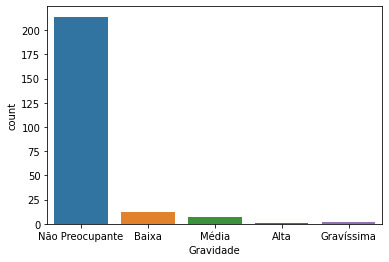

In [48]:
sns.countplot(df_final['Gravidade'])

In [49]:
df_final_pie = df_final.groupby('Gravidade', axis=0).count()
df_final_pie.sort_values(['Pais'], ascending=True, axis=0, inplace=True)
df_final_pie[['Pais']]

,Pais
Gravidade,
Alta,1
Gravíssima,2
Média,7
Baixa,12
Não Preocupante,214


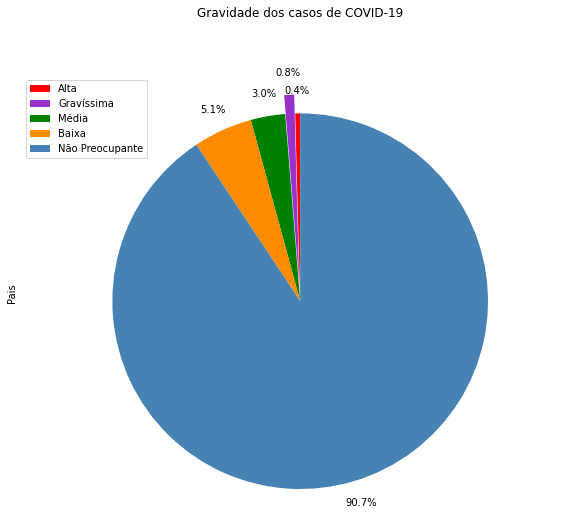

In [50]:
# Gráfico de pizza com os dados dos 10 países que mais imigraram para o Canadá
explode_lista = [0, 0.1, 0, 0, 0] 

df_final_pie['Pais'].plot(kind='pie',
                            figsize=(10, 8), #tamanho do gráfico
                            autopct='%1.1f%%', #mostra em percentagem
                            startangle=90,  #ângulo inicial 90°   
                            #shadow=True, #adiciona sombra 
                            labels=None, #adiciona legendas nas fatias do gráfico
                            colors=['red', 'darkorchid', 'green', 'darkorange', 'steelblue'],                 
                            pctdistance=1.12,            
                            explode=explode_lista #separa as fatias do gráfico       
                            )
                            
plt.title('Gravidade dos casos de COVID-19', y=1.12) 
plt.axis('equal') 

plt.legend(labels=df_final_pie.index, loc='upper left') 

plt.show()

In [51]:
def plot_segmento(x,y,data):
    sns.set(palette='muted', color_codes=True, style='whitegrid')
    fig, axs = plt.subplots(1, 1, figsize=(7, 7))
    sns.despine(left=True)
    sns.scatterplot(x=x, y=y, hue='Gravidade', data=data, size='Gravidade', sizes=(50,150), size_order=['Gravíssima','Alta','Média','Baixa', 'Não Preocupante'])
    axs.set_title('Gravidade dos Casos de Covid')
    plt.show()

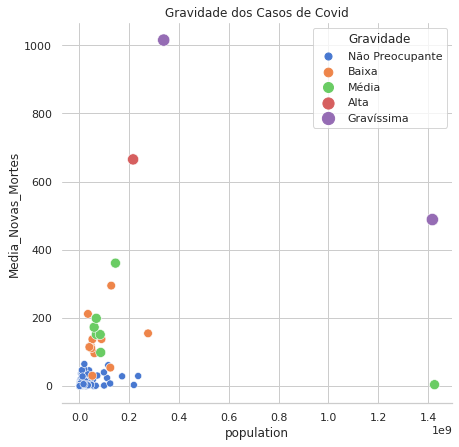

In [52]:
plot_segmento('population','Media_Novas_Mortes',df_final)

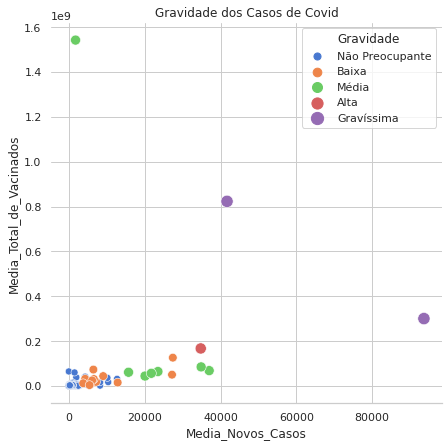

In [53]:
plot_segmento('Media_Novos_Casos','Media_Total_de_Vacinados',df_final)

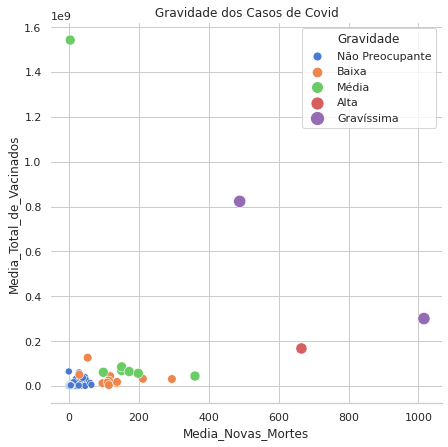

In [54]:
plot_segmento('Media_Novas_Mortes','Media_Total_de_Vacinados',df_final)

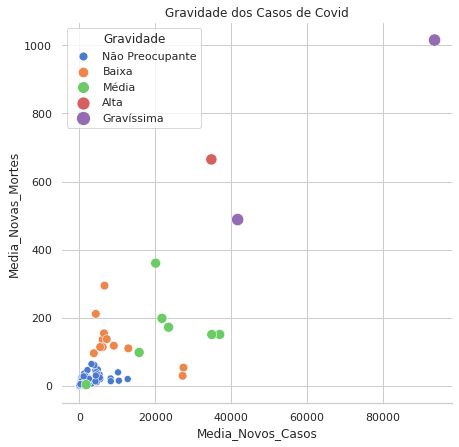

In [55]:
plot_segmento('Media_Novos_Casos','Media_Novas_Mortes',df_final)

In [56]:
df_gravidade_0 = df_final[df_final['Pontuacao']==0]
df_gravidade_0[['Pais','Media_Novos_Casos','Media_Total_de_Vacinados','Media_Novas_Mortes','Gravidade']].head()

,Pais,Media_Novos_Casos,Media_Total_de_Vacinados,Media_Novas_Mortes,Gravidade
0,Afghanistan,198.59,477270.45,7.50,Não Preocupante
1,Albania,319.44,354844.52,3.44,Não Preocupante
2,Algeria,259.56,285547.61,6.58,Não Preocupante
3,Andorra,45.96,4569.84,0.16,Não Preocupante
4,Angola,102.93,869973.22,1.89,Não Preocupante


In [57]:
df_gravidade_0.sort_values(['Media_Novas_Mortes'], ascending=False, axis=0, inplace=True)
df_gravidade_0_top10 = df_gravidade_0.head(10)
df_gravidade_0_top10[['Pais','Media_Novas_Mortes','Gravidade']]

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Pais,Media_Novas_Mortes,Gravidade
157,Romania,64.57,Não Preocupante
152,Philippines,61.11,Não Preocupante
38,Chile,48.66,Não Preocupante
85,Hungary,46.72,Não Preocupante
33,Canada,46.02,Não Preocupante
48,Czechia,40.58,Não Preocupante
207,Vietnam,40.06,Não Preocupante
28,Bulgaria,36.90,Não Preocupante
112,Malaysia,34.24,Não Preocupante
73,Greece,33.31,Não Preocupante


In [61]:
print("Países com Gravidade não Preocupante")
data = dict(
    number=df_gravidade_0_top10['Media_Novas_Mortes'],
    stage=["Romania", "Philippines", "Chile", "Hungary", "Canada","Czechia","Vietnam","Bulgaria","Malaysia","Greece"])
fig = px.funnel(data, x='number', y='stage',color_discrete_sequence=px.colors.qualitative.Plotly)
fig.show()

Países com Gravidade não Preocupante


In [59]:
df_gravidade_1 = df_final[df_final['Pontuacao']==1]
df_gravidade_1[['Pais','Media_Novos_Casos','Media_Total_de_Vacinados','Media_Novas_Mortes','Gravidade']]

,Pais,Media_Novos_Casos,Media_Total_de_Vacinados,Media_Novas_Mortes,Gravidade
214,Japan,27427.31,126313979.41,53.92,Baixa
215,South Korea,27213.41,50506601.32,30.05,Baixa
217,Argentina,9057.91,44235228.63,118.34,Baixa
218,Colombia,6122.38,12726013.16,137.08,Baixa
219,Indonesia,6469.39,73301474.13,154.63,Baixa
220,Iran,7194.62,18463019.52,137.67,Baixa
221,Mexico,6599.15,31118919.66,294.71,Baixa
222,Peru,4312.41,32114232.53,211.72,Baixa
223,Poland,6142.73,24904297.14,114.32,Baixa
224,South Africa,3792.00,12424373.30,96.19,Baixa


In [60]:
df_gravidade_1.sort_values(['Media_Novas_Mortes'], ascending=False, axis=0, inplace=True)
df_gravidade_1[['Pais', 'Media_Novas_Mortes','Gravidade']]

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Pais,Media_Novas_Mortes,Gravidade
221,Mexico,294.71,Baixa
222,Peru,211.72,Baixa
219,Indonesia,154.63,Baixa
220,Iran,137.67,Baixa
218,Colombia,137.08,Baixa
217,Argentina,118.34,Baixa
226,Ukraine,114.39,Baixa
223,Poland,114.32,Baixa
225,Spain,110.48,Baixa
224,South Africa,96.19,Baixa


In [66]:
print("Países com Gravidade Baixa")
data = dict(
    number=df_gravidade_1['Media_Novas_Mortes'],
    stage=["Mexico", "Peru", "Indonesia", "Iran", "Colombia","Argentina","Ukraine","Poland","Spain","South Africa","Japan","South Korea"])
fig = px.funnel(data, x='number', y='stage',color_discrete_sequence=["darkorange"])
fig.show()

Países com Gravidade Baixa


In [67]:
df_gravidade_2 = df_final[df_final['Pontuacao']==2]
df_gravidade_2[['Pais','Media_Novos_Casos','Media_Total_de_Vacinados','Media_Novas_Mortes','Gravidade']]

,Pais,Media_Novos_Casos,Media_Total_de_Vacinados,Media_Novas_Mortes,Gravidade
216,China,1769.58,1542132816.22,3.94,Média
227,France,37013.73,68639615.36,151.31,Média
228,Germany,34893.34,85183476.05,151.08,Média
229,Italy,23498.93,64498828.29,172.59,Média
230,Russia,20098.79,44434160.73,360.72,Média
231,Turkey,15747.08,61306541.72,98.54,Média
232,United Kingdom,21754.32,56717037.36,198.68,Média


In [68]:
df_gravidade_2.sort_values(['Media_Novas_Mortes'], ascending=False, axis=0, inplace=True)
df_gravidade_2[['Pais','Media_Novas_Mortes', 'Gravidade']]

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Pais,Media_Novas_Mortes,Gravidade
230,Russia,360.72,Média
232,United Kingdom,198.68,Média
229,Italy,172.59,Média
227,France,151.31,Média
228,Germany,151.08,Média
231,Turkey,98.54,Média
216,China,3.94,Média


In [69]:
print("Países com Gravidade Média")
data = dict(
    number=df_gravidade_2['Media_Novas_Mortes'],
    stage=["Russia", "United Kingdom", "Italy", "France", "Germany","Turkey","China"])
fig = px.funnel(data, x='number', y='stage',color_discrete_sequence=["green"])
fig.show()

Países com Gravidade Média


In [70]:
df_gravidade_3 = df_final[df_final['Pontuacao']==3]
df_gravidade_3[['Pais','Media_Novas_Mortes','Gravidade']]

,Pais,Media_Novas_Mortes,Gravidade
233,Brazil,665.22,Alta


In [71]:
print("Países com Gravidade Alta")
data = dict(
    number=df_gravidade_3['Media_Novas_Mortes'],
    stage=["Brazil"])
fig = px.funnel(data, x='number', y='stage',color_discrete_sequence=["red"])
fig.show()

Países com Gravidade Alta


In [72]:
df_gravidade_4 = df_final[df_final['Pontuacao']==4]
df_gravidade_4[['Pais','Media_Novos_Casos','Media_Total_de_Vacinados','Media_Novas_Mortes','Gravidade']]

,Pais,Media_Novos_Casos,Media_Total_de_Vacinados,Media_Novas_Mortes,Gravidade
234,United States,93646.00,300525512.28,1015.52,Gravíssima
235,India,41720.34,823188827.49,488.64,Gravíssima


In [74]:
df_gravidade_4[['Pais','Media_Novas_Mortes','Gravidade']]

,Pais,Media_Novas_Mortes,Gravidade
234,United States,1015.52,Gravíssima
235,India,488.64,Gravíssima


In [75]:
print("Países com Pandemia Gravíssima")
data = dict(
    number=df_gravidade_4['Media_Novas_Mortes'],
    stage=["	United States", "	United States	"])
fig = px.funnel(data, x='number', y='stage',color_discrete_sequence=["darkorchid"])
fig.show()

Países com Pandemia Gravíssima


In [ ]:
df_grafico_barra = df_final[['Media_Novos_Casos', 'Media_Total_de_Vacinados', 'Media_Novas_Mortes', 'Gravidade','population']]

In [ ]:
df_grafico_barra.set_index('Gravidade', inplace=True)
df_grafico_barra

,Media_Novos_Casos,Media_Total_de_Vacinados,Media_Novas_Mortes,population
Gravidade,,,,
Não Preocupante,198.59,477270.45,7.50,41128772.00
Não Preocupante,319.44,354844.52,3.44,2842318.00
Não Preocupante,259.56,285547.61,6.58,44903228.00
Não Preocupante,45.96,4569.84,0.16,79843.00
Não Preocupante,102.93,869973.22,1.89,35588996.00
...,...,...,...,...
Média,15747.08,61306541.72,98.54,85341248.00
Média,21754.32,56717037.36,198.68,67508936.00
Alta,34787.54,167426960.68,665.22,215313504.00


In [ ]:
df_grafico_barra = df_grafico_barra.groupby('Gravidade').max()

In [ ]:
df_grafico_barra_novos_casos = df_grafico_barra[['Media_Novos_Casos']]
df_grafico_barra_novos_casos.sort_values(['Media_Novos_Casos'], ascending=False, axis=0, inplace=True)
df_grafico_barra_novos_casos

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Media_Novos_Casos
Gravidade,
Gravíssima,93646.00
Média,37013.73
Alta,34787.54
Baixa,27427.31
Não Preocupante,12724.11


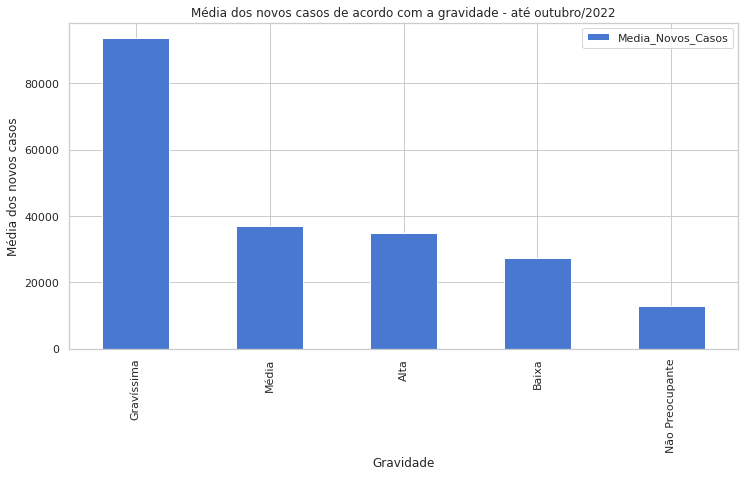

In [ ]:
# Gráfico de barra vertical com os dados da Media_Novos_Casos
df_grafico_barra_novos_casos.plot(kind='bar', figsize=(12, 6), rot=90)
plt.title('Média dos novos casos de acordo com a gravidade - até outubro/2022')
plt.ylabel('Média dos novos casos')
plt.xlabel('Gravidade') 

plt.show()

In [ ]:
df_grafico_barra_total_vaciandos = df_grafico_barra[['Media_Total_de_Vacinados']]
df_grafico_barra_total_vaciandos.sort_values(['Media_Total_de_Vacinados'], ascending=False, axis=0, inplace=True)
df_grafico_barra_total_vaciandos

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Media_Total_de_Vacinados
Gravidade,
Média,1542132816.22
Gravíssima,823188827.49
Alta,167426960.68
Baixa,126313979.41
Não Preocupante,64845858.13


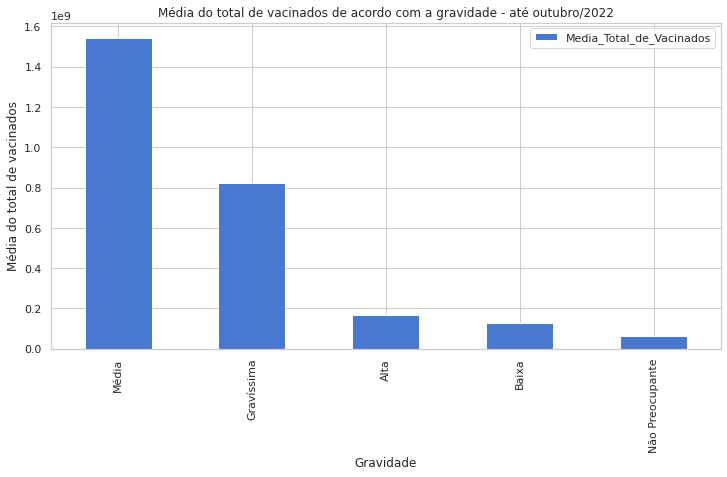

In [ ]:
# Gráfico de barra vertical com os dados da Media_Total_de_Vacinados
df_grafico_barra_total_vaciandos.plot(kind='bar', figsize=(12, 6), rot=90)
plt.title('Média do total de vacinados de acordo com a gravidade - até outubro/2022')
plt.ylabel('Média do total de vacinados')
plt.xlabel('Gravidade') 

plt.show()

In [ ]:
df_grafico_barra_novas_mortes = df_grafico_barra[['Media_Novas_Mortes']]
df_grafico_barra_novas_mortes.sort_values(['Media_Novas_Mortes'], ascending=False, axis=0, inplace=True)
df_grafico_barra_novas_mortes

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Media_Novas_Mortes
Gravidade,
Gravíssima,1015.52
Alta,665.22
Média,360.72
Baixa,294.71
Não Preocupante,64.57


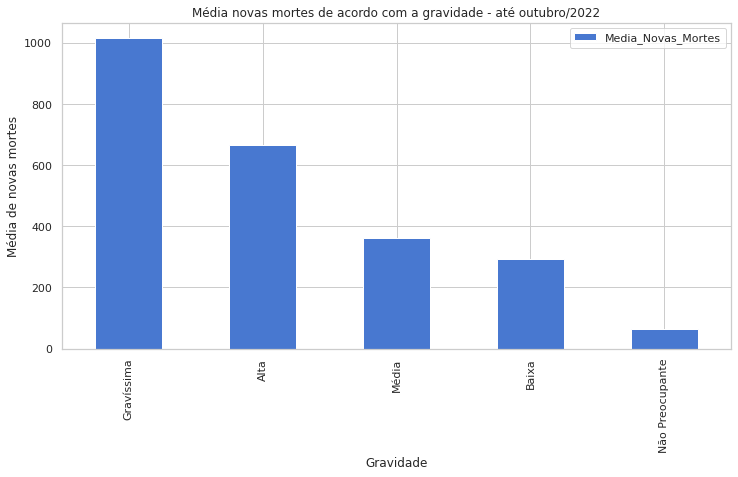

In [ ]:
# Gráfico de barra vertical com os dados da Media_Novas_Mortes
df_grafico_barra_novas_mortes.plot(kind='bar', figsize=(12, 6), rot=90)
plt.title('Média novas mortes de acordo com a gravidade - até outubro/2022')
plt.ylabel('Média de novas mortes')
plt.xlabel('Gravidade') 

plt.show()

In [ ]:
df_grafico_barra_populacao = df_grafico_barra[['population']]
df_grafico_barra_populacao.sort_values(['population'], ascending=False, axis=0, inplace=True)
df_grafico_barra_populacao

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,population
Gravidade,
Média,1425887360.00
Gravíssima,1417173120.00
Baixa,275501344.00
Não Preocupante,235824864.00
Alta,215313504.00


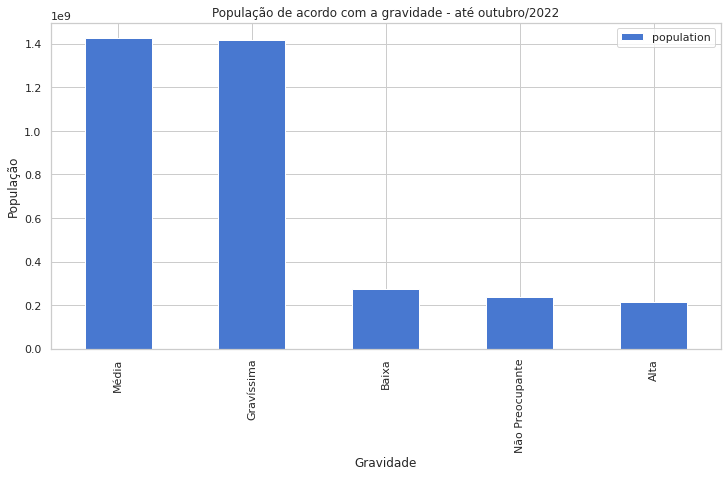

In [ ]:
# Gráfico de barra vertical com os dados da Media_Novas_Mortes
df_grafico_barra_populacao.plot(kind='bar', figsize=(12, 6), rot=90)
plt.title('População de acordo com a gravidade - até outubro/2022')
plt.ylabel('População')
plt.xlabel('Gravidade') 

plt.show()